# Half-cell models in PyBaMM

PyBaMM supports both negative and positive half-cells. In both cases, the working electrode is considered to be the positive electrode and lithium metal the negative electrode. The difference is solely down to the material the positive electrode is made of. This notebook demonstrates how to simulate half-cells made of a range of materials.

In [1]:
%pip install pybamm -q  # install PyBaMM if it is not installed
import pybamm
import matplotlib.pyplot as plt

Note: you may need to restart the kernel to use updated packages.


First, we introduce a random seed to ensure reproducibility of the results before running the simulation:

In [2]:
import numpy as np

np.random.seed(42)

To simulate a half-cell, pass `{"working electrode": "positive"}` to the options dictionary. This deletes the negative electrode and replaces it with lithium metal, which has a fixed open-circuit voltage of zero. First, we load the NMC-based positive half-cell studied by Xu _et al._ [14]

In [3]:
model = pybamm.lithium_ion.DFN({"working electrode": "positive"})
param_nmc = pybamm.ParameterValues("Xu2019")

Start by simulating a pseudo-OCV cycle:

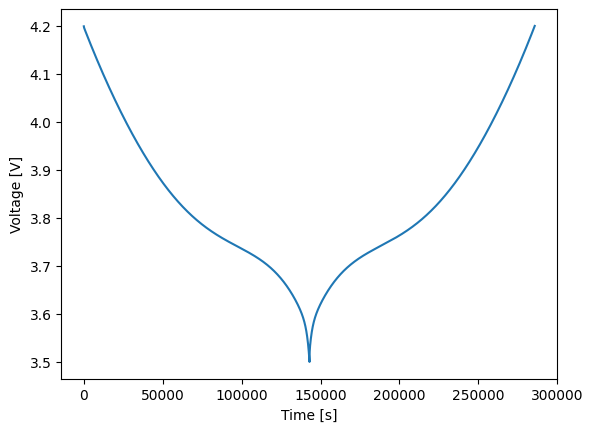

In [4]:
exp_slow = pybamm.Experiment(
    ["Discharge at C/25 until 3.5 V", "Charge at C/25 until 4.2 V"]
)
sim1 = pybamm.Simulation(model, parameter_values=param_nmc, experiment=exp_slow)
sol1 = sim1.solve()
t = sol1["Time [s]"].entries
V = sol1["Voltage [V]"].entries
plt.figure()
plt.plot(t, V)
plt.xlabel("Time [s]")
plt.ylabel("Voltage [V]")
plt.show()

The charge and discharge curves are the same, as expected. This is not the case for faster cycles:

At t = 285.669, , mxstep steps taken before reaching tout.


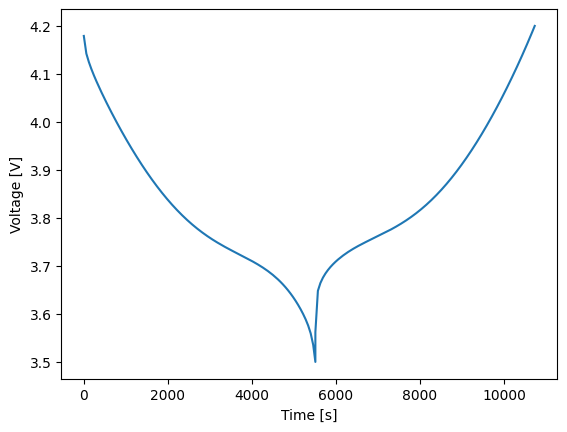

In [5]:
exp_fast = pybamm.Experiment(
    ["Discharge at 1C until 3.5 V", "Charge at 1C until 4.2 V"]
)
sim2 = pybamm.Simulation(model, parameter_values=param_nmc, experiment=exp_fast)
sol2 = sim2.solve()
t = sol2["Time [s]"].entries
V = sol2["Voltage [V]"].entries
plt.figure()
plt.plot(t, V)
plt.xlabel("Time [s]")
plt.ylabel("Voltage [V]")
plt.show()

Next, load a negative half-cell with a graphite-silicon composite as the positive electrode. This is the negative half of the full cell studied by O'Kane _et al._ [11] and therefore supports all the degradation mechanisms included in that paper. Just like in the [coupled degradation notebook](https://docs.pybamm.org/en/latest/source/examples/notebooks/models/coupled-degradation.html), use the options dictionary to switch the mechanisms on and off. Unlike for a full cell, the `SEI` option applies to the lithium metal electrode as well as the positive electrode. To set different options for each, use a 2-tuple. The `SEI on cracks` and `lithium plating` options do not work on the lithium metal electrode.

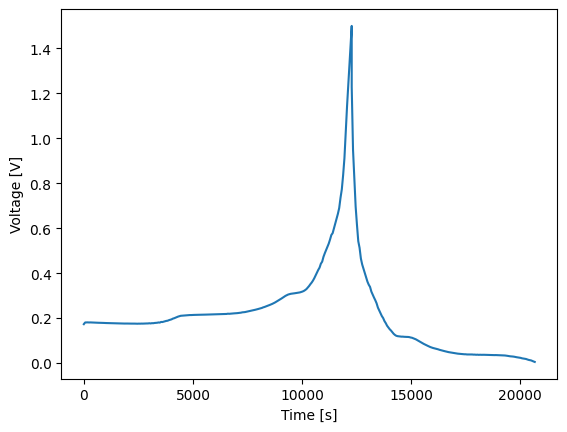

In [6]:
model_with_degradation = pybamm.lithium_ion.DFN(
    {
        "working electrode": "positive",
        "SEI": "reaction limited",  # SEI on both electrodes
        "SEI porosity change": "true",
        "particle mechanics": "swelling and cracking",
        "SEI on cracks": "true",
        "lithium plating": "partially reversible",
        "lithium plating porosity change": "true",  # alias for "SEI porosity change"
    }
)
param_GrSi = pybamm.ParameterValues("OKane2022_graphite_SiOx_halfcell")
param_GrSi.update({"SEI reaction exchange current density [A.m-2]": 1.5e-07})
var_pts = {"x_n": 1, "x_s": 5, "x_p": 7, "r_n": 1, "r_p": 30}
exp_degradation = pybamm.Experiment(
    ["Charge at 0.3C until 1.5 V", "Discharge at 0.3C until 0.005 V"]
)
sim3 = pybamm.Simulation(
    model_with_degradation,
    parameter_values=param_GrSi,
    experiment=exp_degradation,
    var_pts=var_pts,
)
sol3 = sim3.solve()
t = sol3["Time [s]"].entries
V = sol3["Voltage [V]"].entries
plt.figure()
plt.plot(t, V)
plt.xlabel("Time [s]")
plt.ylabel("Voltage [V]")
plt.show()

In order to get SEI growth to work on both electrodes, we had to add domains to the names of the degradation variables. Bear this in mind when writing your code.

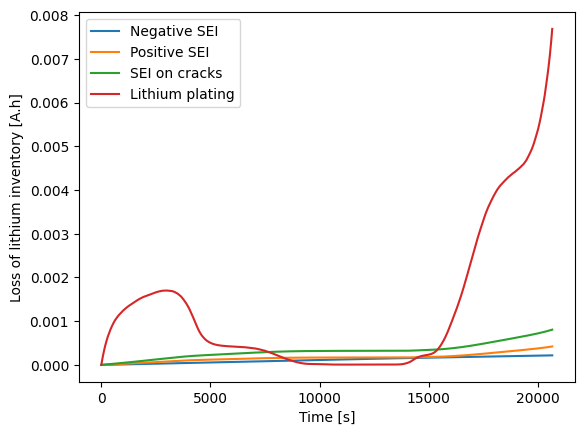

In [7]:
Q_SEI_n = sol3["Loss of capacity to negative SEI [A.h]"].entries
Q_SEI_p = sol3["Loss of capacity to positive SEI [A.h]"].entries
Q_SEI_cr = sol3["Loss of capacity to positive SEI on cracks [A.h]"].entries
Q_pl = sol3["Loss of capacity to positive lithium plating [A.h]"].entries
plt.figure()
plt.plot(t, Q_SEI_n, label="Negative SEI")
plt.plot(t, Q_SEI_p, label="Positive SEI")
plt.plot(t, Q_SEI_cr, label="SEI on cracks")
plt.plot(t, Q_pl, label="Lithium plating")
plt.xlabel("Time [s]")
plt.ylabel("Loss of lithium inventory [A.h]")
plt.legend()
plt.show()

The SEI growth is slow compared to the reversible component of the lithium plating. What happens if the SEI growth rate is increased?

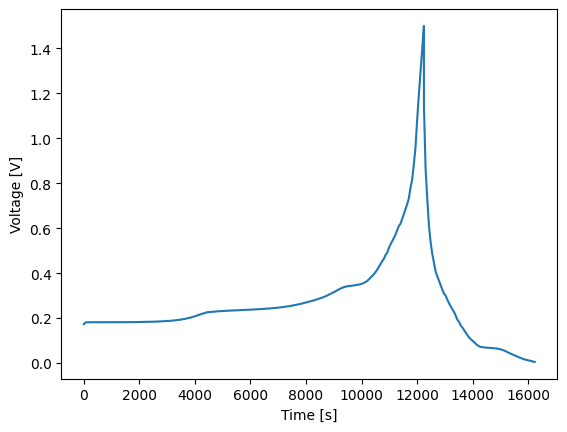

In [8]:
param_GrSi.update({"SEI reaction exchange current density [A.m-2]": 6e-07})
sim4 = pybamm.Simulation(
    model_with_degradation,
    parameter_values=param_GrSi,
    experiment=exp_degradation,
    var_pts=var_pts,
)
sol4 = sim4.solve()
t = sol4["Time [s]"].entries
V = sol4["Voltage [V]"].entries
plt.figure()
plt.plot(t, V)
plt.xlabel("Time [s]")
plt.ylabel("Voltage [V]")
plt.show()

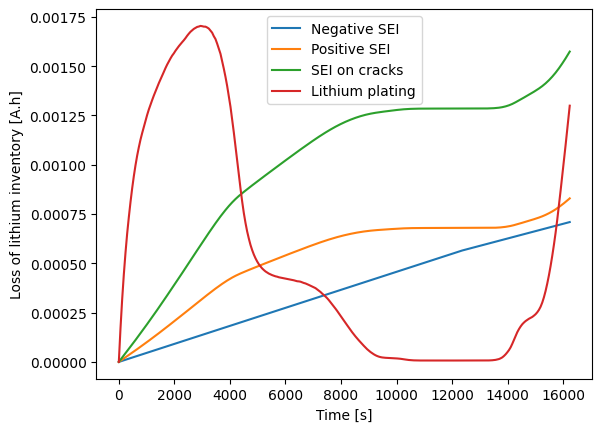

In [9]:
Q_SEI_n = sol4["Loss of capacity to negative SEI [A.h]"].entries
Q_SEI_p = sol4["Loss of capacity to positive SEI [A.h]"].entries
Q_SEI_cr = sol4["Loss of capacity to positive SEI on cracks [A.h]"].entries
Q_pl = sol4["Loss of capacity to positive lithium plating [A.h]"].entries
plt.figure()
plt.plot(t, Q_SEI_n, label="Negative SEI")
plt.plot(t, Q_SEI_p, label="Positive SEI")
plt.plot(t, Q_SEI_cr, label="SEI on cracks")
plt.plot(t, Q_pl, label="Lithium plating")
plt.xlabel("Time [s]")
plt.ylabel("Loss of lithium inventory [A.h]")
plt.legend()
plt.show()

The additional SEI increases the cell resistance, preventing the graphite-silicon composite from being fully lithiated, so there is less plating than before.

In [10]:
pybamm.print_citations()

[1] Weilong Ai, Ludwig Kraft, Johannes Sturm, Andreas Jossen, and Billy Wu. Electrochemical thermal-mechanical modelling of stress inhomogeneity in lithium-ion pouch cells. Journal of The Electrochemical Society, 167(1):013512, 2019. doi:10.1149/2.0122001JES.
[2] Joel A. E. Andersson, Joris Gillis, Greg Horn, James B. Rawlings, and Moritz Diehl. CasADi – A software framework for nonlinear optimization and optimal control. Mathematical Programming Computation, 11(1):1–36, 2019. doi:10.1007/s12532-018-0139-4.
[3] Von DAG Bruggeman. Berechnung verschiedener physikalischer konstanten von heterogenen substanzen. i. dielektrizitätskonstanten und leitfähigkeiten der mischkörper aus isotropen substanzen. Annalen der physik, 416(7):636–664, 1935.
[4] Chang-Hui Chen, Ferran Brosa Planella, Kieran O'Regan, Dominika Gastol, W. Dhammika Widanage, and Emma Kendrick. Development of Experimental Techniques for Parameterization of Multi-scale Lithium-ion Battery Models. Journal of The Electrochemical S